In [1]:
from keras import layers, models
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef,multilabel_confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

### Reading pre-processed NSL_KDD dataset with re-sampled data

- 0 - Normal
- 1 - DoS
- 2 - Probe
- 3 - R2L
- 4 - U2R

In [2]:
filename = "nsl_8K5.csv"
dfxy = pd.read_csv(filename)
Xf = dfxy.iloc[:,1:-1]
yf = dfxy.iloc[:,-1]
Xf = np.asarray(Xf).astype(np.float64)
yf.value_counts()

0    4525
1    2861
2     947
4     269
3     100
Name: attack_map, dtype: int64

In [3]:
one_hot_labels = np.zeros((yf.shape[0], 5))
for i in range(yf.shape[0]):
    one_hot_labels[i, yf[i]] = 1

In [4]:
Xf.shape

(8702, 28)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(Xf, one_hot_labels, test_size=0.30, random_state=4, stratify=yf)

In [6]:
x_train2 = x_train.reshape(-1,1,28)
x_test2 = x_test.reshape(-1,1,28)
y_train2 = y_train.reshape(-1,1,5)
y_test2 = y_test.reshape(-1,1,5)

In [7]:
(x_train).shape

(6091, 28)

### Model Training - Shivam Kumar

Epoch 1/40
610/610 [==============================] - 4s 5ms/step - loss: 0.8990 - accuracy: 0.6656 - val_loss: 0.2428 - val_accuracy: 0.9211
Epoch 2/40
610/610 [==============================] - 2s 4ms/step - loss: 0.1857 - accuracy: 0.9418 - val_loss: 0.1182 - val_accuracy: 0.9674
Epoch 3/40
610/610 [==============================] - 2s 3ms/step - loss: 0.0992 - accuracy: 0.9757 - val_loss: 0.0792 - val_accuracy: 0.9797
Epoch 4/40
610/610 [==============================] - 2s 3ms/step - loss: 0.0717 - accuracy: 0.9783 - val_loss: 0.0666 - val_accuracy: 0.9782
Epoch 5/40
610/610 [==============================] - 2s 3ms/step - loss: 0.0634 - accuracy: 0.9775 - val_loss: 0.0560 - val_accuracy: 0.9801
Epoch 6/40
610/610 [==============================] - 2s 3ms/step - loss: 0.0491 - accuracy: 0.9810 - val_loss: 0.0508 - val_accuracy: 0.9820
Epoch 7/40
610/610 [==============================] - 2s 3ms/step - loss: 0.0513 - accuracy: 0.9803 - val_loss: 0.0492 - val_accuracy: 0.9809
Epoch 

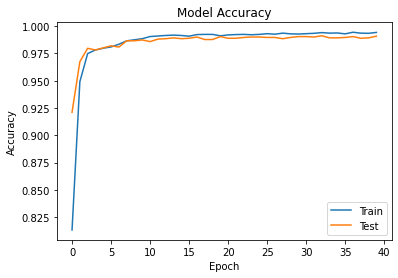

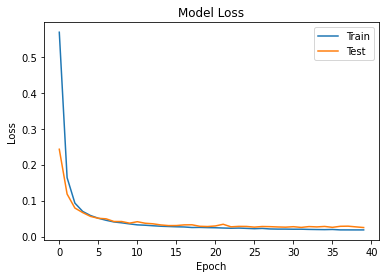

In [8]:
model = models.Sequential()
model.add(Dense(12,input_shape = (None,28),activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history1 = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=40, batch_size=10)
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

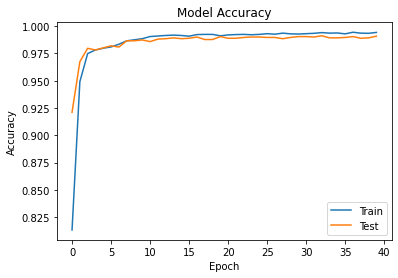

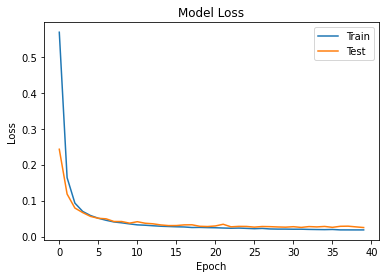

In [11]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

### Testing first model - Rathin Kumar

Category-wise 0:Normal 1:DoS 2:Probe 3:U2R 4:R2L


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1358
           1       1.00      1.00      1.00       858
           2       0.98      0.98      0.98       284
           3       0.86      0.60      0.71        30
           4       0.86      0.96      0.91        81

    accuracy                           0.99      2611
   macro avg       0.94      0.91      0.92      2611
weighted avg       0.99      0.99      0.99      2611

[[1358    0    0    0    0]
 [   0  854    3    0    1]
 [   0    3  279    1    1]
 [   0    0    1   18   11]
 [   0    0    1    2   78]]
Confusion matrix, without normalization


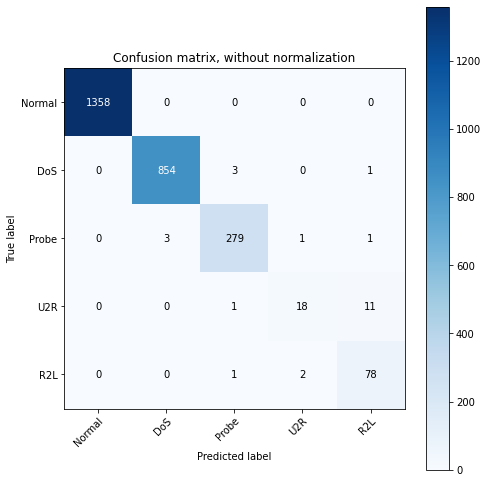

In [17]:
y_pred = model.predict(x_test)
evaluate_model(y_pred.reshape(y_pred.shape[0], 5), y_test.reshape(y_test.shape[0], 5))

### Generate Adversarial Samples - Divya D Kulkarni

In [18]:
def adversarial_pattern(x, attack_map):
    x = tf.cast(x, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(x)
        prediction = model(x)
#         print(prediction)
        loss = tf.keras.losses.MSE(attack_map, prediction)
    
    gradient = tape.gradient(loss, x)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [19]:
def generate_adversarials(batch_size, feat):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 6090)

            attack_map = y_train[N]
            features = x_train[N]
            
            perturbations = adversarial_pattern(features.reshape((1,28)), attack_map).numpy()
#             print(perturbations)
            epsilon = 0.1
            for i in feat:
                adversarial = features[i] + perturbations[0][i] * epsilon
                features[i] =  adversarial
            x.append(features)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, 28))
        y = np.asarray(y).reshape((batch_size, 5))
        
        yield x, y

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [21]:
def accuracy(pred, test):
    
    y_p = np.argmax(pred, axis=1)
    y_tr = np.argmax(test, axis=1)
    print(accuracy_score(y_tr,y_p))

In [22]:
def evaluate_model( pred, test):
    
    y_p = np.argmax(pred, axis=1)
    y_tr = np.argmax(test, axis=1)
    
    mcm = multilabel_confusion_matrix(test, np.round(pred))
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]

    print("Category-wise 0:Normal 1:DoS 2:Probe 3:U2R 4:R2L\n\n")

    # print("true negative rate: ",np.round(tn / (tn + fp),2))
    # print("false positive rate: ", np.round(fp / (fp + tn),2))

    print(classification_report(y_tr,y_p))
    print(confusion_matrix(y_tr,y_p))
    confusion_mtx=confusion_matrix(y_tr,y_p)

    class_names=['Normal','DoS','Probe','U2R','R2L']

    # Plotting non-normalized confusion matrix
    plot_confusion_matrix(y_tr, y_p, classes = class_names,title = 'Confusion matrix, without normalization')

In [29]:
# add perturbations to each feature, one at a time, and check affect on accuracy
# this is to choose features that affect the accuracy the most
for i in range(28):
    feat = np.array([i])
    x_adversarial, y_adversarial = next(generate_adversarials(2500, feat))
    x_adversarial_train, x_adversarial_test, y_adversarial_train, y_adversarial_test = train_test_split(x_adversarial, y_adversarial, test_size=0.20, random_state=4, stratify=y_adversarial)
    y_adv_pred = model.predict(x_adversarial_test)
    accuracy(y_adv_pred.reshape(y_adv_pred.shape[0], 5), y_adversarial_test.reshape(y_adversarial_test.shape[0], 5))

0.894
0.922
0.896
0.898
0.906
0.864
0.894
0.89
0.872
0.884
0.862
0.828
0.822
0.818
0.836
0.838
0.802
0.796
0.806
0.78
0.79
0.79
0.76
0.796
0.8
0.734
0.708
0.69


In [30]:
# add perturbations to only specific features of the dataset that affect accuracy
# and generate 2500 adversarial samples
feat = np.array([19,20,21,22,23,24,25,26,27])
x_adversarial, y_adversarial = next(generate_adversarials(2500, feat))

#split into training and testing sets
x_adversarial_train, x_adversarial_test, y_adversarial_train, y_adversarial_test = train_test_split(x_adversarial, y_adversarial, test_size=0.33, random_state=4, stratify=y_adversarial)

In [31]:
# predict for adversarial testing set with original model
y_adv_pred = model.predict(x_adversarial_test)

### Evaluating first model with adversarial samples

Category-wise 0:Normal 1:DoS 2:Probe 3:U2R 4:R2L


              precision    recall  f1-score   support

           0       0.91      0.47      0.62       438
           1       0.27      0.40      0.32       257
           2       0.04      0.06      0.05        98
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        24

    accuracy                           0.38       825
   macro avg       0.24      0.18      0.20       825
weighted avg       0.57      0.38      0.43       825

[[204 201  15   1  17]
 [  0 102 140   0  15]
 [ 21  68   6   1   2]
 [  0   0   0   0   8]
 [  0   4   0  20   0]]
Confusion matrix, without normalization


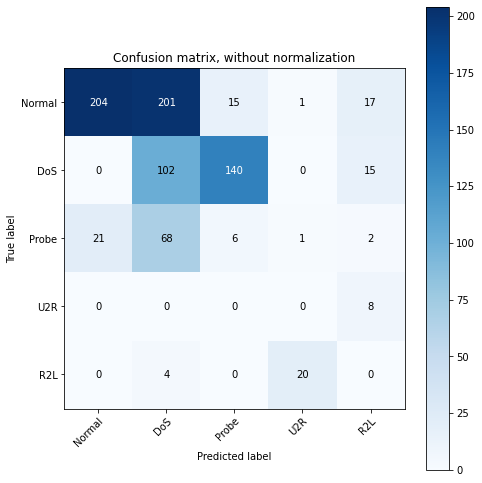

In [32]:
evaluate_model(y_adv_pred.reshape(y_adv_pred.shape[0], 5), y_adversarial_test.reshape(y_adversarial_test.shape[0], 5))

Epoch 1/40
168/168 [==============================] - 1s 4ms/step - loss: 1.0307 - accuracy: 0.8185 - val_loss: 0.4476 - val_accuracy: 0.8885
Epoch 2/40
168/168 [==============================] - 1s 4ms/step - loss: 0.3443 - accuracy: 0.8985 - val_loss: 0.2804 - val_accuracy: 0.9188
Epoch 3/40
168/168 [==============================] - 1s 4ms/step - loss: 0.2316 - accuracy: 0.9224 - val_loss: 0.2093 - val_accuracy: 0.9394
Epoch 4/40
168/168 [==============================] - 1s 6ms/step - loss: 0.1737 - accuracy: 0.9451 - val_loss: 0.1644 - val_accuracy: 0.9467
Epoch 5/40
168/168 [==============================] - 1s 4ms/step - loss: 0.1420 - accuracy: 0.9516 - val_loss: 0.1372 - val_accuracy: 0.9503
Epoch 6/40
168/168 [==============================] - 1s 4ms/step - loss: 0.1179 - accuracy: 0.9588 - val_loss: 0.1224 - val_accuracy: 0.9600
Epoch 7/40
168/168 [==============================] - 1s 4ms/step - loss: 0.1023 - accuracy: 0.9654 - val_loss: 0.1062 - val_accuracy: 0.9624
Epoch 

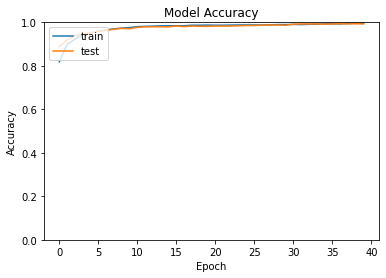

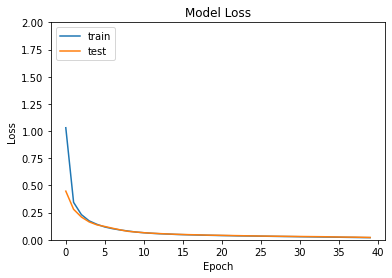

In [33]:
# retrain model with adversarial samples

history = model.fit(x_adversarial_train, y_adversarial_train, batch_size=10, epochs=40,validation_data=(x_adversarial_test, y_adversarial_test))
                                                                                                                                                 
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,2])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

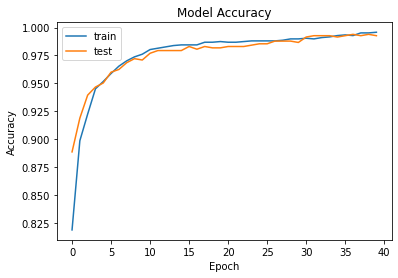

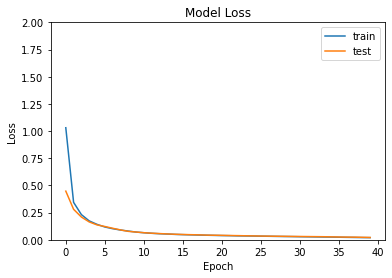

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0,1])
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,2])
plt.legend(['train', 'test'], loc='best')
plt.show()

### Evaluating re-trained model with adversarial samples

Category-wise 0:Normal 1:DoS 2:Probe 3:U2R 4:R2L


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       0.99      0.99      0.99       257
           2       0.98      0.98      0.98        98
           3       1.00      0.75      0.86         8
           4       0.92      1.00      0.96        24

    accuracy                           0.99       825
   macro avg       0.98      0.94      0.96       825
weighted avg       0.99      0.99      0.99       825

[[438   0   0   0   0]
 [  0 255   2   0   0]
 [  0   2  96   0   0]
 [  0   0   0   6   2]
 [  0   0   0   0  24]]
Confusion matrix, without normalization


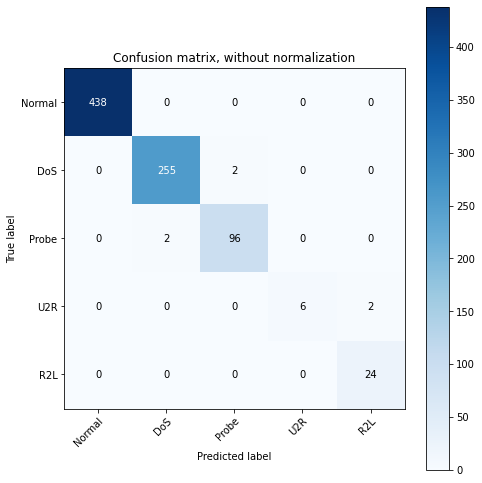

In [34]:
y_adv_pred = model.predict(x_adversarial_test)
evaluate_model(y_adv_pred.reshape(y_adv_pred.shape[0], 5), y_adversarial_test.reshape(y_adversarial_test.shape[0], 5))

### Evaluating first model with original test samples

Category-wise 0:Normal 1:DoS 2:Probe 3:U2R 4:R2L


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1358
           1       0.95      0.97      0.96       858
           2       0.92      0.85      0.88       284
           3       0.09      0.13      0.11        30
           4       0.52      0.47      0.49        81

    accuracy                           0.95      2611
   macro avg       0.70      0.68      0.69      2611
weighted avg       0.95      0.95      0.95      2611

[[1358    0    0    0    0]
 [   0  829   21    0    8]
 [   0   39  242    2    1]
 [   0    0    0    4   26]
 [   0    4    0   39   38]]
Confusion matrix, without normalization


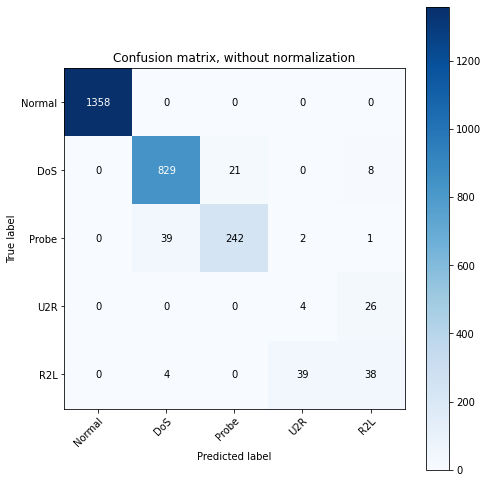

In [35]:
y_pred = model.predict(x_test)
evaluate_model(y_pred.reshape(y_pred.shape[0], 5), y_test.reshape(y_test.shape[0], 5))